# Conductance synapse decoding demo

In this demo I establish a communication channel between two rate-based neuron populations with conductance based synapses.

In [116]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import nengo_conductance_synapses.lif_cond_utils as lif_cond_utils

import seaborn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's find the neuron parameters $a$, $b$, $c$, $d$ for a neuron population with $100$ neurons, maximum firing rate in the range between $50$ and $100$ and an $x$-intercept distribution between $-0.95$ and $0.95$ and plot the corresponding tuning curves.

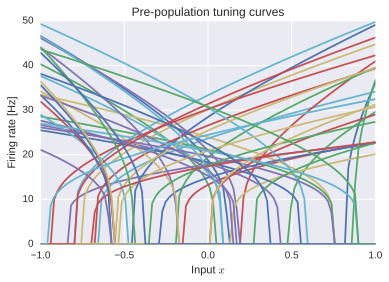

In [188]:
%autoreload

gL = 50 # ==> tau_rc = 20e-3
tau_ref = 2e-3
e_rev_E = 4.33
e_rev_I = -0.33

N_pre = 50
N_post = 60

def fetch_parameters(N):
    a, b, c, d = np.zeros((4, N))
    for i in range(N):
        _, a[i], b[i], c[i], d[i] = lif_cond_utils.solve_max_rate_x_intercept(
            np.random.uniform(-0.95, 0.95),
            np.random.uniform(20, 50),
            gL=gL,
            tau_ref=tau_ref,
            e_rev_E=e_rev_E,
            e_rev_I=e_rev_I,
            fan_in=1)
    return a, b, c, d

encoders_pre = np.random.choice([-1, 1], (1, N_pre))
encoders_post = np.random.choice([-1, 1], (1, N_post))

a_pre, b_pre, c_pre, d_pre = fetch_parameters(N_pre)
a_post, b_post, c_post, d_post = fetch_parameters(N_post)

xs = np.linspace(-1, 1, 100).reshape(-1, 1)
activities_pre = lif_cond_utils.get_activities(
    xs, encoders_pre, a_pre, b_pre, c_pre, d_pre,
    gL=gL, tau_ref=tau_ref,
    e_rev_E=e_rev_E, e_rev_I=e_rev_I)

fig, ax = plt.subplots()
ax.plot(xs, activities_pre);
ax.set_title('Pre-population tuning curves')
ax.set_xlabel('Input $x$')
ax.set_ylabel('Firing rate [Hz]');

Now let's solve for the weight matrices $W^+$ and $W^-$. Plot the linear functions $g_E$ and $g_I$ that are being decoded from the pre-population for each neuron in the post-population.

13.4334399207


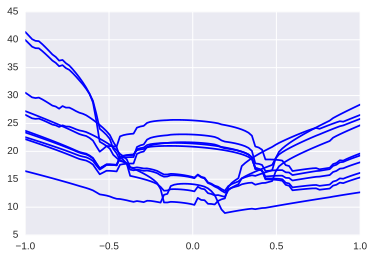

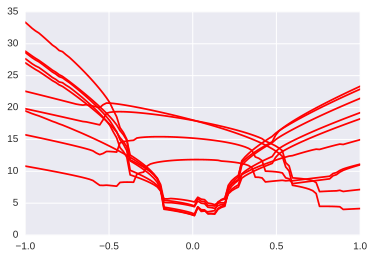

In [207]:
%autoreload

targets = np.cos(np.pi * xs)

# Target activities
activities_post = lif_cond_utils.get_activities(targets, encoders_post, a_post, b_post, c_post, d_post, gL)

# Solve for the connection weights between the pre and post
# population
WE, WI = lif_cond_utils.solve_weight_matrices_for_activities(
    activities_pre, activities_post, gL)


# Fetch gE and gI
gE = activities_pre @ WE
gI = activities_pre @ WI

# Plot the decoded functions for gE
fig, ax = plt.subplots()
ax.plot(xs, (activities_pre @ WE)[:, 0:10], color='blue');

# Plot the decoded functions for gI
fig, ax = plt.subplots()
ax.plot(xs, (activities_pre @ WI)[:, 0:10], color='red');

Now let's plot the tuning curves of the post-population depending on the input to the pre-population.

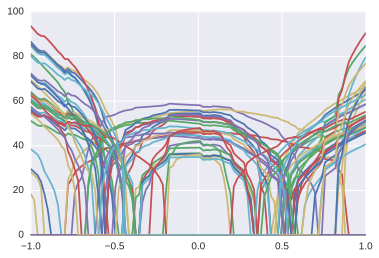

In [208]:
gE = activities_pre @ WE
gI = activities_pre @ WI

activities_post = lif_cond_utils.lif_cond_rate(gL, gE, gI, e_rev_E, e_rev_I, tau_ref)
fig, ax = plt.subplots()
ax.plot(xs, activities_post);

Decode the output of the post population.

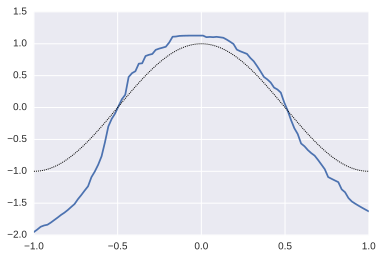

In [209]:
import nengo.solvers

post_tuning = lif_cond_utils.get_activities(
    xs, encoders_post,
    a_post, b_post, c_post, d_post,
    gL, tau_ref, e_rev_E, e_rev_I)
decoders = nengo.solvers.LstsqL2()(post_tuning, xs)[0]

output = activities_post @ decoders

fig, ax = plt.subplots()
ax.plot(xs, output)
ax.plot(xs, targets, color="black", linewidth=1, linestyle=(0, (1, 1)));